In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Latex
#%matplotlib ipympl

#pd.options.plotting.backend = "plotly"

#import logging
# from pyspedas.cotrans.cotrans_get_coord import cotrans_get_coord
# from pyspedas.cotrans.cotrans import cotrans
# from pyspedas.cotrans.gsm2lmn import gsm2lmn
#from pyspedas.mms import mec
#from pyspedas import tinterpol, omni
import os


save_fig = 'no'
# save_csv = 'no'

save_images = 'no'
save_csv = 'no'


den_csv = 'MMS2_ni.csv'
mag_arr_str = 'MMS2_B.csv'
v_arr_str = 'MMS2_Vi.csv'

temp_perp = 'MMS2_Tiperp.csv'

temp_para = 'MMS2_Tipara.csv'

pressure_anisotropy = 'pressure_anisotropy.csv'

alpha = pd.read_csv(pressure_anisotropy,header = 0,names = ['times','alpha','date'],
                         parse_dates=['date'])
mag_arr = pd.read_csv(mag_arr_str,header = 0,names = ['times','Bx','By','Bz','Bmag','date'],
                         parse_dates=['date'])
v_arr = pd.read_csv(v_arr_str,header = 0,names = ['times','Vix','Viy','Viz','date'],
                         parse_dates=['date'])

den_csv = pd.read_csv(den_csv,header = 0,names = ['times','Ni','date'],
                         parse_dates=['date'])



Tipara_csv = pd.read_csv(temp_para,header = 0,names = ['times','Tipara','date'],
                         parse_dates=['date'])

Tiperp_csv = pd.read_csv(temp_perp,header = 0,names = ['times','Tiperp','date'],
                         parse_dates=['date'])

In [2]:
Tipara_csv

,times,Tipara,date
0,1.592426e+09,512.64154,2020-06-17 20:29:23.206896128
1,1.592426e+09,521.43690,2020-06-17 20:29:23.356896000
2,1.592426e+09,507.57720,2020-06-17 20:29:23.506895872
3,1.592426e+09,469.81030,2020-06-17 20:29:23.656896000
4,1.592426e+09,484.21317,2020-06-17 20:29:23.806896128
...,...,...,...
120259,1.592444e+09,313.19037,2020-06-18 01:30:02.312813056
120260,1.592444e+09,313.87143,2020-06-18 01:30:02.462812928
120261,1.592444e+09,298.44138,2020-06-18 01:30:02.612813056
120262,1.592444e+09,319.52860,2020-06-18 01:30:02.762812928


In [3]:
 def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return int(idx)

# Minimum Variance Analysis

In [4]:
from numpy import linalg as LA
# #########################
# #GET MAGNETIC FIELD DATA#
# #########################
def mms_mvab(m1,m2,mag_arr_str):
    mag_arr = pd.read_csv(mag_arr_str,header = 0,names = ['times','Bx','By','Bz','Bmag','date'],
                         parse_dates=['date'])
    m1 = pd.to_datetime(m1)
    m2 = pd.to_datetime(m2)
    # ##########################################################
    # Check for NaN values
    NaNs = mag_arr.isnull().values.any()
    if NaNs == True:
        print,'Nans were found: '
        print, mag_arr.isnull().values.any()
        print,'Replacing with average of surrounding data pts '
        # Indices of NaNs in each component
        NaNs_Bx = np.argwhere(np.isnan(bx))
        NaNs_By = np.argwhere(np.isnan(by))
        NaNs_Bz = np.argwhere(np.isnan(bz))

        # If there are NaNs, replace with the average of surrounding couple of data points
        for i in range(len(NaNs_Bx)):
            bx[NaNs_Bx[i]] = np.nanmean(bx[NaNs_Bx[i-3]:NaNs_Bx[i+3]])
            by[NaNs_By[i]] = np.nanmean(by[NaNs_By[i-3]:NaNs_By[i+3]])
            bz[NaNs_Bz[i]] = np.nanmean(bz[NaNs_Bz[i-3]:NaNs_Bz[i+3]])                           
    time = np.array(mag_arr['times'])
    bx = np.array(pd.to_numeric(mag_arr['Bx']))
    by = np.array(pd.to_numeric(mag_arr['By']))
    bz = np.array(pd.to_numeric(mag_arr['Bz']))
    n1 = mag_arr.date[0]
    n2 = mag_arr.date[len(mag_arr.date)-1]
    if m1 < n1:
        print('WARNING!!! start time of current sheet =',m1, 'start time of B-field data =', n1)
    if m1 > n2:
        print('WARNING!!! start time of current sheet =',m1,'end time of B-field data =',n2)
    if m2 > n2:
        print('WARNING!!! end time of current sheet =',m2,'end time of B-field data =',n2)
    if m2 < n1:
        print('WARNING!!! end time of current sheet =',m2,'start time of B-field data =',n1)
    v1 = mag_arr.date.searchsorted(m1)
    v2 = mag_arr.date.searchsorted(m2)
    bx = bx[v1:v2]
    by = by[v1:v2]
    bz = bz[v1:v2]
    
    
    # create the minimum variance matrix. 
    mm = np.zeros([3, 3])
    bxa = np.mean(bx)
    bya = np.mean(by)
    bza = np.mean(bz)
    mm[0,0] = np.mean(bx*bx) - bxa*bxa
    mm[1,0] = np.mean(bx*by) - bxa*bya
    mm[2,0] = np.mean(bx*bz) - bxa*bza
    mm[0,1] = mm[1,0]
    mm[1,1] = np.mean(by*by) - bya*bya
    mm[2,1] = np.mean(by*bz) - bya*bza
    mm[0,2] = mm[2,0]
    mm[1,2] = mm[2,1]
    mm[2,2] = np.mean(bz*bz) - bza*bza
    
    # The 3 eigenvectors represent directions of maximum, intermediate, and minimum variance of the field
    # component along each vector. 
    
    # The corresponding eigenvalues (λ) represent the actual variances in those field components & are non-negative 
    
    
    # The eigenvector x3 (corresponding to the smallest eigenvalue λ3) is used as the estimator for 
    # the vector normal to the current sheet.
    
    # λ3 represents the variance of the magnetic field component along the estimated normal. 
    
    # The eigenvectors x1 and x2, corresponding to maximum and intermediate variance
    # are tangential to the transition layer
    
    
    
    # eigen vectors should be in GSE coordinate system right?
    eigenvalues, eigenvectors = LA.eig(mm)    
    idx = np.argsort(eigenvalues)
    E_vals_sorted = eigenvalues[idx]
    E_vec_sorted = eigenvectors[:,idx]

    return E_vals_sorted,E_vec_sorted


# Cross-product Normal

In [5]:
# Below are some lines of IDL code to get the cross-product normal.
def Cross_product_normal(E_vals,E_vec,m1,m2,mag_arr_str): 
    mag_arr = pd.read_csv(mag_arr_str,header = 0,names = ['times','Bx','By','Bz','Bmag','date'],
                         parse_dates=['date'])
    m1 = pd.to_datetime(m1)
    m2 = pd.to_datetime(m2)
    
    # lv,mv,nv are in the same coordinate system as the eigenvectors (GSE)
    nv = E_vec[:,0] # take B1 x B2/|B1 x B2|
    lv = E_vec[:,2]
    mv = np.cross(nv,lv)
    rat = E_vals[1]/E_vals[0]
    lxm = lv[0]
    lym = lv[1]
    lzm = lv[2]
    mxm = mv[0]
    mym = mv[1]
    mzm = mv[2]
    nxm = nv[0]
    nym = nv[1]
    nzm = nv[2]
    time = np.array(mag_arr['times'])
    bx = np.array(pd.to_numeric(mag_arr['Bx']))
    by = np.array(pd.to_numeric(mag_arr['By']))
    bz = np.array(pd.to_numeric(mag_arr['Bz']))
    # search the B-field array date column for m1
    v1 = mag_arr.date.searchsorted(m1)
    v2 = mag_arr.date.searchsorted(m2)
    
    # pick a time delta 
    dtb = pd.Timedelta(hours = 0, minutes = 0, seconds = 2)
    v1a = mag_arr.date.searchsorted(m1 - dtb)
    v2a = mag_arr.date.searchsorted(m2 + dtb)
    bv1x = bx[v1a:v1]
    bv1y = by[v1a:v1]
    bv1z = bz[v1a:v1]
    bv2x = bx[v2:v2a]
    bv2y = by[v2:v2a]
    bv2z = bz[v2:v2a]
    bv1avg = np.array([np.mean(bv1x),np.mean(bv1y),np.mean(bv1z)])
    bv2avg = np.array([np.mean(bv2x),np.mean(bv2y),np.mean(bv2z)])
    bmag1 = np.sqrt(np.sum(np.dot(bv1avg,bv1avg)))
    # original bmag2 = np.sqrt(np.sum(np.multiply(bv2avg,bv2avg)))
    bmag2 = np.sqrt(np.sum(np.dot(bv2avg,bv2avg)))
    normal = np.cross(bv1avg,bv2avg)
    normag = np.sqrt(np.sum(np.dot(normal,normal)))
    nc = normal/normag  # N-direction
    # print('nc',nc)
    # print('nc[1]',nc[1])
    # #Angle between cross-product & MVAB normals
    #n12ang = np.arccos(np.sum(nv*nc))*180./!dpi
    
    #not sure if we need this part
    n12ang = np.arccos(np.sum(nv*nc))*180
    # if n12ang >= 90.0:
    #     nc = -nc

# TEST 1
# flip $N_{GSE}$ to $-N_{GSE}$ if needed for all events with $N_{y}>0$
    if nym > 0:
        #print('y coordinate of N is > 0')
        nc =-nc

#    #TEST 2
# # flip $N_{GSE}$ to $-N_{GSE}$ if needed for all events with $N_{y}>0$
    # if nc[1] > 0:
    #     nyc = -nc[1]
    # else:
    #     nyc = nc[1]
        
    mvec = np.cross(nc,E_vec[:,2])
    mmag = np.sqrt(np.sum(np.dot(mvec,mvec)))
    mc = mvec/mmag    # M-direction
    lc = np.cross(mc,nc)  # L-direction
    # angle = np.arccos(np.sum(np.multiply(E_vec[:,2],lc)))*180
    # Angle between cross-product & MVAB normals
    #n12ang = np.arccos(np.sum(np.dot(nv,nc)))*180
    #print('n12ang:',n12ang)
    lxc = lc[0]
    lyc = lc[1]
    lzc = lc[2]
    mxc = mc[0]
    myc = mc[1]
    mzc = mc[2]
    nxc = nc[0]
    nyc = nc[1]
    nzc = nc[2]
    nang = n12ang
    
    # display(Latex(f'$n_c \cdot l_c =$ {np.dot(nc,lc):.2f}')) 
    # display(Latex(f'$m_c \cdot l_c =$ {np.dot(mc,lc):.2f}'))
    # display(Latex(f'$n_c \cdot m_c =$ {np.dot(nc,mc):.2f}'))

#     display(Latex(f"$L_x =$ {lxc:.2f}"))
#     display(Latex(f"$L_y =$ {lyc:.2f}"))
#     display(Latex(f"$L_z =$ {lzc:.2f}"))
    
#     display(Latex(f"$L_xm =$ {lxm:.2f}"))
#     display(Latex(f"$L_ym =$ {lym:.2f}"))
#     display(Latex(f"$L_zm =$ {lzm:.2f}"))

    # print('Lc: ',lc)
    # print('Mc: ',mc)
    # print('Nc: ',nc)
    display(Latex(f"$L_GSE = $ [{lxc:.2f}, {lyc:.2f}, {lzc:.2f}]"))
    display(Latex(f"$M_GSE = $ [{mxc:.2f}, {myc:.2f}, {mzc:.2f}]"))
    display(Latex(f"$N_GSE = $ [{nxc:.2f}, {nyc:.2f}, {nzc:.2f}]"))
    # print('L vector magnitude',np.sqrt(lc[0]**2+lc[1]**2+lc[2]**2))
    # print('M vector magnitude',np.sqrt(mc[0]**2+mc[1]**2+mc[2]**2))
    # print('N vector magnitude',np.sqrt(nc[0]**2+nc[1]**2+nc[2]**2))
    # print('Lv: ',lv)
    # print('Mv: ',mv)
    # print('Nv: ',nv)
    
    return lc,mc,nc,lv,mv,nv,mag_arr['date'][v1a],mag_arr['date'][v2a]

# Stefan identified jet candidates

In [6]:
#tmidx = '2020-06-17/21:41:10.000'
#tmidx = None



# Events with clear peak velocity exhausts
#tmidx = '2020-06-17/21:11:36' #1
#tmidx = '2020-06-17/21:16:40' #2
#tmidx = '2020-06-17/21:16:50' #3
#tmidx = '2020-06-17/21:25:01' #4
#tmidx = '2020-06-17/21:29:15' #5
#tmidx = '2020-06-17/21:41:10' #6
#tmidx = '2020-06-17/22:43:50' #9
#tmidx = '2020-06-17/23:03:54.100' #11
#tmidx = '2020-06-17/23:17:22.900' #14
#tmidx = '2020-06-17/23:35:08' #15

#tmidx = '2020-06-17/23:37:10' #16
#tmidx = '2020-06-17/23:42:52.500' #17
#tmidx = '2020-06-17/23:58:12' #19



# jet_candidate_timeranges = np.array([['2020-06-17/21:16:50.000','2020-06-17/21:17:10.000'], #3 wonderful example
# ['2020-06-17/21:24:34.000','2020-06-17/21:25:22.000'], #4 
# ['2020-06-17/21:40:49.000','2020-06-17/21:41:23.000'], #6 
# ['2020-06-17/22:18:14.500','2020-06-17/22:18:32.000'], #8 
# ['2020-06-17/22:43:33.000','2020-06-17/22:44:05.000'], #9 2 merging jets
# ['2020-06-17/22:46:24.000','2020-06-17/22:46:39.000'], #10
# ['2020-06-17/23:03:49.000','2020-06-17/23:03:59.000'], #11  great example
# ['2020-06-17/23:10:42.000','2020-06-17/23:10:53.000'], #13 
# ['2020-06-17/23:17:16.000','2020-06-17/23:17:29.000'], #14 
# ['2020-06-17/23:34:54.000','2020-06-17/23:35:18.000'], # 15 
# ['2020-06-17/23:42:45.000','2020-06-17/23:43:02.000'], #17 
# ['2020-06-17/23:49:23.000','2020-06-17/23:49:49.000'], #18 
# ['2020-06-17/23:57:55.000','2020-06-17/23:58:27.000'], #19 
# ['2020-06-18/00:09:40.000','2020-06-18/00:10:06.000'], #21
# ['2020-06-18/00:22:08.000','2020-06-18/00:22:36.000']]) #22

# times_temp =np.array([['2020-06-17/21:16:55.000','2020-06-17/21:17:07.000'], #3 
# ['2020-06-17/21:24:36.000','2020-06-17/21:25:20.000'], #4
# ['2020-06-17/21:40:51.400','2020-06-17/21:41:20.799'], #6 
# ['2020-06-17/22:18:18.200','2020-06-17/22:18:31.000'], #8
# ['2020-06-17/22:43:34.000','2020-06-17/22:44:03.599'], #9
# ['2020-06-17/22:46:25.250','2020-06-17/22:46:38.500'],#10
# ['2020-06-17/23:03:50.000','2020-06-17/23:03:58.000'], #11
# ['2020-06-17/23:10:43.000','2020-06-17/23:10:52.000'], #13
# ['2020-06-17/23:17:17.299','2020-06-17/23:17:28.000'], #14
# ['2020-06-17/23:34:55.400','2020-06-17/23:35:17.500'], #15
# ['2020-06-17/23:42:47.000','2020-06-17/23:42:59.000'], #17
# ['2020-06-17/23:49:26.400','2020-06-17/23:49:46.350'], #18
# ['2020-06-17/23:57:57.599','2020-06-17/23:58:25.000'], #19
# ['2020-06-18/00:09:41.000','2020-06-18/00:10:05.000'], #21
# ['2020-06-18/00:22:09.000','2020-06-18/00:22:35.599']]) #22
# print(jet_candidate_timeranges)

# # actual times of the start and stop of current sheet:
#times_temp = ['2020-06-17/21:11:26.000','2020-06-17/21:11:48.000'] #1 don't include in L_GSE and N_GSE coord pplot
#times_temp = ['2020-06-17/21:16:26','2020-06-17/21:16:42'] #2 include
#times_temp =['2020-06-17/21:16:55.000','2020-06-17/21:17:07.000'] #3 
#times_temp =['2020-06-17/21:24:36.000','2020-06-17/21:25:20.000'] #4 include
#times_temp =['2020-06-17/21:29:09.200','2020-06-17/21:29:19.150'] #5 include
#times_temp =['2020-06-17/21:40:51.400','2020-06-17/21:41:20.799'] #6 include

#times_temp =['2020-06-17/22:18:18.200','2020-06-17/22:18:31.000']#8
# #Suggestion to move ['2020-06-17/22:43:48.299','2020-06-17/22:44:03.599’] to ['2020-06-17/22:43:34','2020-06-17/22:44:03.599’]
#times_temp =['2020-06-17/22:43:34','2020-06-17/22:44:03.599'] #9
#times_temp =['2020-06-17/22:46:25.500','2020-06-17/22:46:39.099']#10
# # '2020-06-17/23:03:35.000','2020-06-17/23:03:35.500',
#times_temp =['2020-06-17/23:03:50.000','2020-06-17/23:03:58.000'] #11
#times_temp =['2020-06-17/23:08:35.700','2020-06-17/23:08:57.400']#12
#times_temp = ['2020-06-17/23:10:43.000','2020-06-17/23:10:52.00'] #13
#times_temp =['2020-06-17/23:17:17.299','2020-06-17/23:17:28.000'] #14
#times_temp =['2020-06-17/23:34:55.400','2020-06-17/23:35:17.500'] #15
#times_temp =['2020-06-17/23:36:57.600','2020-06-17/23:37:26.500'] #16
#times_temp =['2020-06-17/23:42:47.000','2020-06-17/23:42:59.000'] #17
#times_temp =['2020-06-17/23:49:26.400','2020-06-17/23:49:46.350'] #18
#times_temp =['2020-06-17/23:57:57.599','2020-06-17/23:58:25.000'] #19
# # #times_temp =['2020-06-18/00:04:58.599','2020-06-18/00:05:11.099'] #20
times_temp =['2020-06-18/00:09:41.000','2020-06-18/00:10:05.000'] #21
# # #suggestion to move start time from 00:22:14.000 to 00:22:09.000
#times_temp =['2020-06-18/00:22:09.000','2020-06-18/00:22:35.599'] #22

# # ################ ################ ################ ################ ################ 
# # # Stefan identified time ranges, but altering the start and stop time to produce best L results
# # ################ ################ ################ ################ ################ 
#jet_candidate_timeranges = np.array([['2020-06-17/21:11:25','2020-06-17/21:11:49']]) #1 
#jet_candidate_timeranges = np.array([['2020-06-17/21:16:25','2020-06-17/21:16:43']]) #2 # got it pretty good I think
#jet_candidate_timeranges = np.array([['2020-06-17/21:16:50','2020-06-17/21:17:10']]) #3 # got it pretty good I think
#jet_candidate_timeranges = np.array([['2020-06-17/21:24:34','2020-06-17/21:25:22.00']]) #4 # good looking event
#jet_candidate_timeranges = np.array([['2020-06-17/21:29:08.000','2020-06-17/21:29:20']]) #5# good looking event
#jet_candidate_timeranges = np.array([['2020-06-17/21:40:49','2020-06-17/21:41:23']]) #6 okay looking
#jet_candidate_timeranges  =np.array([['2020-06-17/22:18:16.200','2020-06-17/22:18:33.000']])#8
#jet_candidate_timeranges =np.array([['2020-06-17/22:43:33.00','2020-06-17/22:44:05.00']]) #9 ehh
#jet_candidate_timeranges=np.array([['2020-06-17/22:46:24.000','2020-06-17/22:46:41.000']])#10 okay looking
#jet_candidate_timeranges = np.array([['2020-06-17/23:03:49.000','2020-06-17/23:03:59.000']]) #11 pretty good
#jet_candidate_timeranges = np.array([['2020-06-17/23:08:35.500','2020-06-17/23:08:59.000']])#12
# # # sugggestion to move the jet candidate event end from 2020-06-17/23:11:22.000 to 23:10:52
#jet_candidate_timeranges =np.array([['2020-06-17/23:10:42.000','2020-06-17/23:10:53.000']]) #13 okay, hard to see peak Vl
#jet_candidate_timeranges =np.array([['2020-06-17/23:17:16','2020-06-17/23:17:29.000']]) #14  pretty good
#jet_candidate_timeranges = np.array([['2020-06-17/23:34:54','2020-06-17/23:35:18']]) # 15 good
#jet_candidate_timeranges =np.array([['2020-06-17/23:36:56.000','2020-06-17/23:37:27.000']]) #16 good; well-defined peak
#jet_candidate_timeranges =np.array([['2020-06-17/23:42:45.000','2020-06-17/23:43:02.000']]) #17 VERY GOOD
#jet_candidate_timeranges = np.array([['2020-06-17/23:49:23.000','2020-06-17/23:49:49.000']]) #18 good; well-defined peak
#jet_candidate_timeranges =np.array([['2020-06-17/23:57:55','2020-06-17/23:58:27']]) #19 good
jet_candidate_timeranges =np.array([['2020-06-18/00:09:39.000','2020-06-18/00:10:07.000']]) #21
#jet_candidate_timeranges = np.array([['2020-06-18/00:22:08.000','2020-06-18/00:22:36']]) #22





# # MSH_time = '2020-06-17/21:11:25' # event 1
# # MSP_time = '2020-06-17/21:11:49' # event 1

# # MSH_time = '2020-06-17/21:16:43' # event 2
# # MSP_time = '2020-06-17/21:16:25' # event 2

# # MSH_time = '2020-06-17/21:16:48' #event 3
# # MSP_time = '2020-06-17/21:17:15'# event 3

# MSH_time = '2020-06-17/21:25:22.00' #event 4
# MSP_time = '2020-06-17/21:24:34'# event 4


# # MSH_time = '2020-06-17/21:29:20' #event 5
# # MSP_time = '2020-06-17/21:29:08'# event 5

# # MSH_time = '2020-06-17/21:41:23' #event 6 I think these are accurate. It's hard to tell on the timeseries plot
# # MSP_time = '2020-06-17/21:40:49'# event 6


# # MSH_time = '2020-06-17/22:44:05' #event 9
# # MSP_time = '2020-06-17/22:43:33'# event 9


# # MSH_time = '2020-06-17/22:46:24' #event 10
# # MSP_time = '2020-06-17/22:46:41'# event 10

# # MSH_time = '2020-06-17/23:03:59.000' #event 11
# #MSP_time = '2020-06-17/23:03:49.000'# event 11

# # MSH_time = '2020-06-17/23:08:35.500' #event 12
# # MSP_time = '2020-06-17/23:08:59.000'# event 12

# # MSH_time = '' #event 13 # i have no idea which side is the MSH or MSP. Both look like MSP
# # MSP_time = ''# event 13

# # MSH_time = '2020-06-17/23:17:16' #event 14
# # MSP_time = '2020-06-17/23:17:29.000'# event 14

# # MSH_time =  #event 15 # no clue. both sides look like MSP
# # MSP_time = # event 15

# # MSH_time = '2020-06-17/23:37:27.000' #event 16
# # MSP_time = '2020-06-17/23:36:56.000'# event 16

# # MSH_time =  #event 17 both are in MSP
# # MSP_time = # event 17

# # MSH_time =  #event 18 both are in MSP
# # MSP_time = # event 18

# # MSH_time = '2020-06-17/23:58:35' #event 19
# # MSP_time = '2020-06-17/23:57:55'# event 19

# # MSH_time =  #event 20
# # MSP_time = # event 20

# # MSH_time =  #event 21
# # MSP_time = # event 21

# Run MVAB analysis

In [7]:
# create an array of datetimes to cycle through to find the best jet_range start and stop times. Save each thing to a png. 
# Review which one produces the most clearest B-field switch and jet peak. Also look at the LN unit vectors to see if they're pointing in the correct direction

# maybe to do this automatically instead of looking through all 180 images, you could find the transformation 
# where the value of Bl at start of CS is greatest distance from end of CS


from datetime import datetime, timedelta


# print('date_list_after_cs')
# print(date_list_after_cs)
# num_sec = 180
# #print(date_list_after_cs)
# # The start time of the current sheet
# base_st = pd.to_datetime(times_temp[0])-timedelta(seconds=180)
# date_list_to_cs = [base_st + timedelta(seconds = x) for x in range(0,num_sec)]
# date_list_to_cs = pd.to_datetime(date_list_to_cs)
# # ['2020-06-17/23:03:35.000','2020-06-17/23:03:59.000']
# # print('date_list_to_cs')
# # print(date_list_to_cs)

# # # The stop time of the current sheet
# base_end = pd.to_datetime(times_temp[1])+timedelta(seconds=1)
# date_list = [base_end + timedelta(seconds=x) for x in range(0,num_sec)]
# date_list_after_cs = pd.to_datetime(date_list)


# fixed_end_time = pd.to_datetime(jet_candidate_timeranges[0,1])
# #also have the option for the end of the time range to only 1 time stamp
# date_list_after_cs_fixed = [fixed_end_time+ timedelta(seconds=0)for x in range(0,num_sec)]
# date_list_after_cs_fixed = pd.to_datetime(date_list_after_cs_fixed)


# # also have the option for using a fixed start time
# fixed_st_time = pd.to_datetime(jet_candidate_timeranges[0,0])
# date_list_to_cs_fixed = [fixed_st_time + timedelta(seconds=0) for x in range(0,num_sec)]
# date_list_to_cs_fixed = pd.to_datetime(date_list_to_cs_fixed)
# #print(date_list_after_cs_fixed)

#print(date_list_after_cs)
# jet_candidate_timeranges = ((np.stack((date_list_to_cs,date_list_after_cs),axis=1)))
# print('jet_candidate_timeranges')
# #print(jet_candidate_timeranges)

#variable start times, fixed end time
#jet_candidate_timeranges = np.array((np.stack((date_list_to_cs,date_list_after_cs_fixed),axis=1)))

# fixed start time, variable end time
#jet_candidate_timeranges = np.array((np.stack((date_list_to_cs_fixed,date_list_after_cs),axis=1)))
#print((jet_candidate_timeranges))
# # print(len(jet_candidate_timeranges[0,0]))

In [8]:
# i = 0
# print(len(jet_candidate_timeranges[i,0]))

In [9]:
# Matplotlib plotting
#%matplotlib widget
# %matplotlib ipympl

# # create empty lists to store all of the L M N coordinates in
# all_l = np.empty((len(jet_candidate_timeranges[:,0]),3))
# all_m = np.empty((len(jet_candidate_timeranges[:,0]),3))
# all_n = np.empty((len(jet_candidate_timeranges[:,0]),3))

best_lmn_transformations = []

for i in range(len(jet_candidate_timeranges)):
    # create empty lists to store all of the L M N coordinates in
    all_l = np.empty((len(jet_candidate_timeranges[:,0]),3))
    all_m = np.empty((len(jet_candidate_timeranges[:,0]),3))
    all_n = np.empty((len(jet_candidate_timeranges[:,0]),3))
    
    dtb = pd.Timedelta(hours = 0, minutes = 0, seconds = 2)

    m1 = pd.to_datetime(jet_candidate_timeranges[i,0])
    m2 = pd.to_datetime(jet_candidate_timeranges[i,1])
    print('event number:',i+1)

    time_b = np.array(mag_arr['times'])
    bx = np.array(pd.to_numeric(mag_arr['Bx']))
    by = np.array(pd.to_numeric(mag_arr['By']))
    bz = np.array(pd.to_numeric(mag_arr['Bz']))

    time_v = np.array(v_arr['times'])
    vx = np.array(pd.to_numeric(v_arr['Vix']))
    vy = np.array(pd.to_numeric(v_arr['Viy']))
    vz = np.array(pd.to_numeric(v_arr['Viz']))
    # t5_v = v_arr.date.searchsorted(m1)
    # t6_v = v_arr.date.searchsorted(m2)
    # uncomment to include data during dtb time:
    t5_v = v_arr.date.searchsorted(m1-dtb)
    t6_v = v_arr.date.searchsorted(m2+dtb)
    # print(t5_v)
    # velocity from specified start (t5) and stop(t6) time of current sheet
    vx_t5_t6 = vx[t5_v:t6_v]
    vy_t5_t6 = vy[t5_v:t6_v]
    vz_t5_t6 = vz[t5_v:t6_v]
    time_v_t5_t6 = time_v[t5_v:t6_v]

    # search the B-field array date column for m1
    t5_b = mag_arr.date.searchsorted(m1)
    t6_b = mag_arr.date.searchsorted(m2)
    # uncomment to include data during dtb time:
    t5_b = mag_arr.date.searchsorted(m1 - dtb)
    t6_b = mag_arr.date.searchsorted(m2 + dtb)

    # B-field from specified start (t5) and stop (t6) time of current sheet
    bx_t5_t6 = bx[t5_b:t6_b]
    by_t5_t6 = by[t5_b:t6_b]
    bz_t5_t6 = bz[t5_b:t6_b]
    time_b_t5_t6 = time_b[t5_b:t6_b]

    # Find Eigenvalues and Eigen vectors from MVAB analysis
    E_vals,E_vec = mms_mvab(m1,m2,mag_arr_str)
    lc,mc,nc,lv,mv,nv,v1a,v2a = Cross_product_normal(E_vals,E_vec,jet_candidate_timeranges[i,0],
                                              jet_candidate_timeranges[i,1],mag_arr_str)
    
    
#     print('L:',lc)
#     print('M:',mc)
#     print('N:',nc)
#     print('\n')

#TEST A
    all_l[i,:] = lv
    all_m[i,:] = mv
    all_n[i,:] = nv
# TEST B    
#     all_l[i,:] = lc
#     all_m[i,:] = mc
#     all_n[i,:] = nc

    
    bn = []
    bl = []
    bm = []
    vn = []
    vl = []
    vm = []
    # for each B-value at each time stamp, project B into LMN coordinates.
    for t in range(len(time_b_t5_t6)):
        bvx_temp = bx_t5_t6[t]
        bvy_temp = by_t5_t6[t]
        bvz_temp = bz_t5_t6[t]
        # create matrix where columns are the x,y,z component at that timestamp to be used in the following dot product
        bvec = np.stack((bvx_temp,bvy_temp,bvz_temp), axis=-1)
        # find dot product between bvec and nc
        bl.append(np.dot(bvec,lc))
        bm.append(np.dot(bvec,mc))
        bn.append(np.dot(bvec,nc))
    # for each v value at each t, project into LMN coordinate system    
    for t in range(len(time_v_t5_t6)):
        # calculate cross product normals using eigen values, eigen vectors, and the start and stop 
        # time for each jet candidate. 
        vx_temp = vx_t5_t6[t]
        vy_temp = vy_t5_t6[t]
        vz_temp = vz_t5_t6[t]
        # create matrix where columns are the x,y,z component at that timestamp to be used in the following dot product
        Vvec = np.stack((vx_temp,vy_temp,vz_temp), axis=-1)
        vl.append(np.dot(Vvec,lc))
        vm.append(np.dot(Vvec,mc))
        vn.append(np.dot(Vvec,nc))

    # create a unique string to name files/images based on the start time of the timerange
    string1 = np.array2string(jet_candidate_timeranges[i,0])
    string2 = np.array2string(jet_candidate_timeranges[i,1])
    #print(string)
    time_period_string1 = string1.replace(":", "_")
    time_period_string1 = time_period_string1.replace("/", "_")
    time_period_string1 = time_period_string1.replace("T", "_")
    time_period_string1 = time_period_string1.replace("'", "_")
    #print( time_period_string)
    # time string has .000 or .000000000 remove them for saving
    if len(time_period_string1) > 19:
        time_period_string1 = time_period_string1[0:20]
        #print(string)

    time_period_string2 = string2.replace(":", "_")
    time_period_string2 = time_period_string2.replace("/", "_")
    time_period_string2 = time_period_string2.replace("T", "_")
    time_period_string2 = time_period_string2.replace("'", "_")
    if len(time_period_string2) > 19:
        time_period_string2 = time_period_string2[0:20]
        #print(string)
    time_period_string = time_period_string1 + time_period_string2

    ################################################
    # Generate B_{LMN} and V_{LMN} data structures!
    ################################################
    MMS2_B_LMN = pd.DataFrame({"times": time_b_t5_t6, "Bl": bl,
                            "Bm": bm, "Bn": bn})

    MMS2_V_LMN = pd.DataFrame({"times": time_v_t5_t6, "Vl": vl,
                            "Vm": vm, "Vn": vn})
    MMS2_B_LMN['date'] = pd.to_datetime(MMS2_B_LMN['times'],unit='s',origin='unix')
    MMS2_V_LMN['date'] = pd.to_datetime(MMS2_V_LMN['times'],unit='s',origin='unix')

    if save_csv == 'yes':
        #  # # optional; save LMN coordinates for velocity and B-field to csv
        MMS2_B_LMN.to_csv(('MMS2_B_LMN'+ time_period_string+'.csv'), index=False)  
        MMS2_V_LMN.to_csv(('MMS2_V_LMN'+ time_period_string+ '.csv'), index=False)  



event number: 1


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [10]:
#MMS2_B_LMN['date']

In [11]:
#MMS2_V_LMN['date']

In [12]:
#len(MMS2_B_LMN['date'])

In [13]:
#len(MMS2_V_LMN['date'])

In [14]:
# Plot the new LMN coordinate system compared to GSE coordinate system

# Show LMN GSE coordinate components relative to XYZ GSE coordinates

In [15]:
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111)


# L_GSE = np.empty((len(jet_candidate_timeranges[:,0])+1,3))
# M_GSE = np.empty((len(jet_candidate_timeranges[:,0])+1,3))
# N_GSE = np.empty((len(jet_candidate_timeranges[:,0])+1,3))
# L_GSE[0,:] = [0,0,0]
# M_GSE[0,:] = [0,0,0]
# N_GSE[0,:] = [0,0,0]

# for i in range(len(jet_candidate_timeranges)):
#     L_GSE[i+1,:] = [all_l[i,0],all_l[i,1],all_l[i,2]]
#     M_GSE[i+1,:] = [all_m[i,0],all_m[i,1],all_m[i,2]]
#     N_GSE[i+1,:] = [all_n[i,0],all_n[i,1],all_n[i,2]]
                     
#     xs = np.array([[0,0],[all_l[i,0],all_l[i,1]]])
#     ys = np.array([[0,0],[all_n[i,0],all_n[i,1]]])

#     ax.plot(xs[:,0],xs[:,1],color='darkturquoise',label='L')
#     ax.plot(ys[:,0],ys[:,1],color='purple',label='N')

# ax.set_xlabel('$X_{GSE}$')
# ax.set_ylabel('$Y_{GSE}$')
# ax.axvline(x = 0, color = 'k')
# ax.axhline(y = 0, color = 'k')
# ax.legend()
# ax.set_ylim([-1,1])
# ax.set_xlim([-1,1])
# ax.set_title('LN Vectors \n '+str(jet_candidate_timeranges[i,0])+' - '+str(jet_candidate_timeranges[i,1]))


# # ax.set_yticklabels([])
# # ax.set_xticklabels([])
# plt.tight_layout()
# plt.show()

# if save_fig == 'yes':
#     fig.savefig('LN_vectors_' + time_period_string)


# print(L_GSE)

# Wálen Analysis

In [16]:
# #Constants
# c = 2.99792458e8  #speed of light (m/s)
# m_e = 9.10939e-31         #electron mass (kg)
# eps0 = 8.8541878e-12  #epsilon (As/Vm)
# e = 1.6022e-19         #charge (C=As)
# my = 4.0*1e-7     #my0 (Vs/Am)
# mp = 1.672623*1e-27    #proton rest mass  (kg)
# kb = 1.38066*1e-23     #Boltzmann constant (J/K) (kg m^2 s^-2)(K^-1)
# μ0 = 1.256637061*1e-6 # N A^-2 #kg m s^-2 A^-2


# tc1 = times_temp[0]
# tc2 = times_temp[1]


# opp = None
# dtref = 2.0
# h2 = None
# suffix = None


# #def walen_auto_lmn(tc1, tc2, bl_csv, vl_csv, den_csv, tmidx=None, opp=None, dtref=None, h2=None, suffix=None):

# # ;walen on ViL component
# # ;
# # tc1 and tc2 are times used for Walen prediction -- format is '2015-09-08/10:23:14' ...
# # 
# # ;
# # ;tmidx - if set to one time on regular string format then use this manual 
# # ;        time instead of automatic time of maximum velocity change
# # ;opp - use opposite sign of the two slopes (opposite to auto selection)
# # ;
# # ;dtref - time (s) for averaging of external ViL reference value
# # ;       defau< is 1.0 s about start time

# #bl_csv - the fi<= with all Bl, Bm, Bn values saved. 

# #vl_csv - the fi<= with all Vl,Vm,Vn values saved. 

# #den_csv - the fi<= with all ion density  values saved. 



# tc1 = pd.to_datetime(tc1)
# tc2 = pd.to_datetime(tc2)
# # print('tc1',tc1)
# # print('tc2',tc2)




# ts = pd.Timestamp(tc1)
# tc1_unix = ts.timestamp()

# ts2 = pd.Timestamp(tc2)
# tc2_unix = ts2.timestamp()

# # tc1_unix = pd.Timestamp(tc1)
# # tc2_unix = pd.Timestamp(tc2)

# print('tc1_unix',tc1_unix)
# print('tc2_unix',tc2_unix)
# print('tc1_unix',pd.to_datetime(tc1_unix,unit='s',origin='unix'))
# print('tc2_unix',pd.to_datetime(tc2_unix,unit='s',origin='unix'))

# b_unix_times = np.array(MMS2_B_LMN['times'])
# vi_unix_times = np.array(MMS2_V_LMN['times'])

# #p_unix_times = np.array()

# # b_unix_times = np.array(mag_arr['times'])
# # vi_unix_times = np.array(mag_arr['times'])


# ind_b1 = find_nearest(b_unix_times,tc1_unix)
# ind_b2 = find_nearest(b_unix_times,tc2_unix)
# print('ind_b1',ind_b1)
# print('ind_b2',ind_b2)


# ind_v1 = find_nearest(vi_unix_times,tc1_unix)
# ind_v2 = find_nearest(vi_unix_times,tc2_unix)

# # print('ind_v1',ind_v1)
# # print('ind_v2',ind_v2)

# if dtref == []:
#     dref = 1.0 
# else: dref = dtref

# dtres   = .15    # FPI cadence (s)

# if not h2:
#     dtres_b = 0.092 
# else: dtres_b = 3.0 # MFI H2 cadence 92 ms

# dnr = np.floor((dref/dtres_b)/2.0)
# #print,dnr

# #print('dnr:',dnr)

# b = np.array(MMS2_B_LMN['Bl'][ind_b1:ind_b2])
# b_time = np.array(b_unix_times[ind_b1:ind_b2])


# bl1 = MMS2_B_LMN['Bl'][ind_b1]
# bl2 = MMS2_B_LMN['Bl'][ind_b2]

# # print(pd.to_datetime(MMS2_B_LMN['date'][ind_b1],unit='s',origin='unix'))
# # print(pd.to_datetime(MMS2_B_LMN['date'][ind_b2],unit='s',origin='unix'))

# b_OG = np.array(MMS2_B_LMN['Bl'])
# vi_OG = np.array(MMS2_V_LMN['Vl'])

# vi = np.array(MMS2_V_LMN['Vl'][ind_v1:ind_v2])

# vl1 = MMS2_V_LMN['Vl'][ind_v1]
# vl2 = MMS2_V_LMN['Vl'][ind_v2]
# vi_time = np.array(vi_unix_times[ind_v1:ind_v2])


# dtcs = tc2_unix - tc1_unix
# #print('dtcs',dtcs)

# closest_indices_b = []
# closest_idx_Bmag =[]

# for t in range(len(vi_time)):
#     idx = find_nearest(b_unix_times, vi_time[t])
#     idx2 = find_nearest(mag_arr['times'], vi_time[t])
#     closest_indices_b.append(idx)
#     closest_idx_Bmag.append(idx2)
#     #closest_times_des.append(datetime.datetime.fromtimestamp(times_des[idx_des]).strftime('%Y-%m-%d %H:%M:%S'))


# Bmag_GSE = mag_arr['Bmag'][closest_idx_Bmag]

# b_time_short = np.array(b_unix_times[closest_indices_b])
# b_short = np.array(b_OG[closest_indices_b])


# den_short = np.array(den_csv['Ni'])

# Tipara_short = np.array(Tipara_csv['Tipara'])*11606 # T in eV convert to K
# Tiperp_short = np.array(Tiperp_csv['Tiperp'])*11606

# # define alphas based on Paschmann et al., 1986

# # P_para = (den_short)*1e6*kb*Tipara_short # P in units of Pa (m^-3)(kg m^2 s^-2 K^-1)(K)
# # P_perp = (den_short)*1e6*kb*Tiperp_short

# P_para =  pd.DataFrame({"times": den_csv['times'], "P_para": (den_short)*1e6*kb*Tipara_short,
#                             "date":pd.to_datetime(den_csv['times'],unit='s') }) # P in units of Pa (m^-3)(kg m^2 s^-2 K^-1)(K)

# P_perp =  pd.DataFrame({"times": den_csv['times'], "P_perp": (den_short)*1e6*kb*Tiperp_short,
#                             "date":pd.to_datetime(den_csv['times'],unit='s') })# P in units of Pa (m^-3)(kg m^2 s^-2 K^-1)(K)

# #Get Walen reference velocity points
# vl1avg = np.mean(vi_OG[ind_v1-int(dnr):ind_v1+int(dnr)])    #dnr pts either side
# vl2avg = np.mean(vi_OG[ind_v2-int(dnr):ind_v2+int(dnr)]) #

# vlmax = np.max(vi)
# vlmin = np.min(vi)

# dvla1 = np.abs(vlmax-vl1)
# dvla2 = np.abs(vlmax-vl2)
# dvla = np.max([dvla1,dvla2])

# dvlb1 = np.abs(vlmin-vl1)
# dvlb2 = np.abs(vlmin-vl2)
# dvlb = np.max([dvlb1,dvlb2])

# #print('dVLa,dVLb:',dvla,dvlb)

# #if (dvla > dvlb) then begin
# if (dvla >= dvlb):
#     print('dvla >= dvlb')
#     sg = 1.0 
#     vlex = vlmax
#     ind = np.argwhere(vi == vlex)
#     #print('ind',ind)
#     #tmid = pd.to_datetime(b_time_short[ind[0]]) 
#     tmid = b_time_short[ind[0]]


# if (dvla < dvlb):
#     print('dvla < dvlb')
#     sg = -1.0
#     vlex = vlmin
#     ind = np.argwhere(vi == vlex)
#     #print('ind',ind)
#   #  tmid = pd.to_datetime(b_time_short[ind[0]]) 
#     tmid = b_time_short[ind[0]]


# if (np.isfinite(dvla) == False) and (np.isfinite(dvlb) == False):
#     print('*** NO dvla and dvlb numbers - SKIP ***')
#     data = pd.DataFrame({"vlobs": -999, "vlpred": -999,"dvl":-999,"topt":tmid})
#   #goto, stop

# # ;At times of exhaust plateau it is advisable to use visual tmidx keyword
# # if the tmidx keyword is set:

# if tmidx:
#     tmidx = pd.to_datetime(tmidx)
#     ts = pd.Timestamp(tmidx)
#     ts2 = ts.timestamp()
#     tmid = np.array(ts2)
#     ind = np.argwhere(b_time_short >= tmid)

    
#     # #ts = datetime.timestamp(tmid)
#     # print(ts)

    
#     #ind = np.argwhere(b_time_short >= ts)



# if opp:
#     sg = -sg


# tmid0 = tmid
# #print('tc1_unix +0.1*dtcs:',tc1_unix +0.1*dtcs)
# ut0 = tc1_unix + 0.1*dtcs


# print('#########################################')
# print('ut0:',ut0, pd.to_datetime(ut0, unit='s',origin='unix'))
# print('#########################################')

# ntmax = np.floor(0.9*dtcs/dtres_b)
# #print('ntmax',ntmax)
# print('b start time:',b_time_short[0], pd.to_datetime(b_time_short[0], unit='s',origin='unix'))
# print('b end time:',b_time_short[len(b_time_short)-1], pd.to_datetime(b_time_short[len(b_time_short)-1], unit='s',origin='unix'))


# Calculate alphas

In [17]:



# ts1 = pd.Timestamp(MSH_time)
# MSH_time = ts1.timestamp()
# print('MSH_time',MSH_time)

# ts = pd.Timestamp(MSP_time)
# MSP_time = ts.timestamp()
# print('MSP_time',MSP_time)


# ind_MSH_b = find_nearest(mag_arr['times'],MSH_time)
# ind_MSP_b = find_nearest(mag_arr['times'],MSP_time)
# ind_MSH_v = find_nearest(v_arr['times'],MSH_time)
# ind_MSP_v = find_nearest(v_arr['times'],MSP_time)


# print('ind_MSH_b',ind_MSH_b)
# print('ind_MSH_v',ind_MSH_v)
# print('ind_MSP_b',ind_MSP_b)
# print('ind_MSP_v',ind_MSP_v)

# # bmag_GSE = []
# # v_time_new = vi_unix_times[ind_v1:ind_v2]
# # for t in range(len(v_time_new)):
# #     idx = find_nearest(mag_arr['times'], v_time_new[t])
# #     bmag_GSE.append(idx)

# # Bmag_GSE = mag_arr['Bmag'][bmag_GSE]
# α1 = ((P_para['P_para'][ind_MSH_v] - P_perp['P_perp'][ind_MSH_v])*(μ0))/(mag_arr['Bmag'][ind_MSH_b]*1e-9)**2 # Pa kg m s^-2 A^-2 /T = (kg m^-1 s^-2)(kg m s^-2 A^-2)/(kg^2 s^-4 A^-2) = unitless
# #α2 = np.array(((P_para[ind_v1:ind_v2] - P_perp[ind_v1:ind_v2])*(μ0))/(mag_arr['Bmag'][bmag_GSE]*1e-9)**2) # Pa kg m s^-2 A^-2 /T = (kg m^-1 s^-2)(kg m s^-2 A^-2)/(kg^2 s^-4 A^-2) = unitless


# #α2 = ((P_para[ind_MSP_v] - P_perp[ind_MSP_v])*(μ0))/(mag_arr['Bmag'][ind_MSP_b]*1e-9)**2 # Pa kg m s^-2 A^-2 /T = (kg m^-1 s^-2)(kg m s^-2 A^-2)/(kg^2 s^-4 A^-2) = unitless

# α2 = ((np.array(P_para['P_para'][ind_v1:ind_v2]) - np.array(P_perp['P_perp'][ind_v1:ind_v2]))*(μ0))/((np.array(Bmag_GSE) *1e-9)**2) # Pa kg m s^-2 A^-2 /T = (kg m^-1 s^-2)(kg m s^-2 A^-2)/(kg^2 s^-4 A^-2) = unitless


# print('P_para MSH',P_para['P_para'][ind_MSH_v])
# print('P_para MSP',P_para['P_para'][ind_MSP_v])


# print('P_perp MSH',P_perp['P_perp'][ind_MSH_v])
# print('P_perp MSP',P_perp['P_perp'][ind_MSP_v])

# print('B MSH',mag_arr['Bmag'][ind_MSH_b])
# print('B MSP',mag_arr['Bmag'][ind_MSP_b])

# print('α1',α1)
# print('α2',α2)




In [18]:
#((P_para['P_para'][ind_v1:ind_v2] - P_perp['P_perp'][ind_v1:ind_v2])*(μ0))/(Bmag_GSE[ind_v1:ind_v2] *1e-9)**2


In [19]:

# dverr = []

# #dverr = np.empty(int(ntmax))
# utc = [] #strarr(ntmax)
# # subscript 1 refers to conditions on the magnetosheath side
# # subscript 2 refers to conditions on the magnetopause side


# # # iterate through to find a tmidx
# # for i in range(int(ntmax)):
# # #for i in range(2):
# #   # ;dt = (float(i))*dtres
# #     dt = (i)*dtres_b
# #     utc_val = ut0 + dt
# #     utc.append(ut0 + dt)
# #     #print('utc_val',utc_val,datetime.fromtimestamp(utc_val))
# #     #print('utc_val',utc_val,pd.to_datetime(utc_val, unit='s',origin='unix'))
# #     # print('utc',utc)
# #     # print('tmid:',tmid, pd.to_datetime(tmid, unit='s',origin='unix'))
   
 
# #     ind1 = np.argwhere((b_time_short >= tc1_unix) & (b_time_short <= utc_val))
# #     ind2 = np.argwhere((b_time_short >= utc_val) & (b_time_short <= tc2_unix))
# #     # ind1 = np.argwhere((b_unix_times >= tc1_unix) & (b_unix_times <= utc_val))
# #     # ind2 = np.argwhere((b_unix_times >= utc_val) & (b_unix_times <= tc2_unix))

# #     # print('b start time:',b_time_short[ind1[0]], pd.to_datetime(b_time_short[ind1[0]], unit='s',origin='unix'))
# #     # print('b end time:',b_time_short[ind2[0]], pd.to_datetime(b_time_short[ind2[0]], unit='s',origin='unix'))


# #     if ind1.size == 0:
# #         print('no matching indices ind1')
# #         print(i)
# #     if ind2.size == 0:
# #         print('no matching indices ind2')
# #         print(i)
# #         continue

# #     # if ind2.size == 0:
# #     #     print('no matching indices ind2')
        
# #     p = len(ind1)-1
# #     q = len(ind2)-1

# #     # Stefan's:
# #     # dval1 = np.sqrt(den_short[ind1[0]]*mp/my)*(b_short[ind1[p]]/(den_short[ind1[p]]*mp) - b_short[ind1[0]]/(den_short[ind1[0]]*mp) )*1e-15 #;vil(km/s)
# #     # dval2 = np.sqrt(den_short[ind2[q]]*mp/my)*( b_short[ind2[0]]/(den_short[ind2[0]]*mp) - b_short[ind2[q]]/(den_short[ind2[q]]*mp) )*1e-15 #;vil(km/s)
    
# #     dval1 = np.sqrt((1 - α1)*(my*mp*(den_short[ind1[0]])*1e6))*(((b_short[ind1[p]])*1e-9*(1-α2[ind1[0]])) - (b_short[ind1[0]])*1e-9*(1-α1)) #;vil(km/s)
# #     dval2 = np.sqrt((1 - α1)*(my*mp*(den_short[ind2[q]])*1e6))*(((b_short[ind2[0]])*1e-9*(1-α2[ind2[0]])) - (b_short[ind2[q]])*1e-9*(1-α1)) #;vil(km/s)
    
 
# #     # print('dval1',dval1)
# #     # print('dval2',dval2)
# #     if (( sg == 1.0 ) & ( bl2 < bl1 )) | (( sg == -1.0 ) & ( bl2 > bl1 )):
# #         dval1= -dval1
# #     if (( sg == 1.0 ) & ( bl1 < bl2 )) | (( sg == -1.0 ) & ( bl1 > bl2 )):
# #         dval2 = -dval2
    
# #     vec1 = np.array(dval1 + vl1avg)
# #     vec2 = np.array(dval2 + vl2avg)
# #     dverr_val = np.abs(vec1 - vec2)
# #     dverr.append(dverr_val)
# #     #dverr[i] = dverr_val
# #     #print('i:',i,'dt:',dt,'dverr:',dverr_val,' ','utc:',utc_val,datetime.fromtimestamp(utc_val))



# # dverr = np.array(dverr)
# # indc = np.argwhere(dverr == np.min(dverr))

# # if len(indc) > 1:
# #     jj = np.array(int(len(indc)/2))
# #     #print('jj',jj)
# # else:
# #     jj = np.array(0)

# # # reshape to a 1 row, n column array
# # indc = indc.reshape(-1)
                          
# # tmid0 = utc[int(indc[int(jj)])]
# # dverr_m = dverr[int(indc[int(jj)])]

# # print('Optimum Walen prediction at ',pd.to_datetime(tmid0, unit='s',origin='unix'),' UT with dVL velocity difference ',dverr_m,' km/s')

# #This keyword will overrule the automatic time
# #if the keyword of tmidx is set:
# if tmidx:
#     tmidx = pd.to_datetime(tmidx)
#     ts = pd.Timestamp(tmidx)
#     ts2 = ts.timestamp()
#     tmid = np.array(ts2)
# else:
#     tmid = tmid0
#     # tmid0 = pd.to_datetime(tmid0)
#     # ts = pd.Timestamp(tmid0)
#     # ts2 = ts.timestamp()
#     # tmid = np.array(ts2)


# ind1 = np.argwhere((b_time_short >= tc1_unix) & (b_time_short <= tmid))
# ind2 = np.argwhere((b_time_short >= tmid) & (b_time_short <= tc2_unix))

# print('tmid:',tmid, pd.to_datetime(tmid, unit='s',origin='unix'))
# print('b start time:',b_time_short[0], pd.to_datetime(b_time_short[0], unit='s',origin='unix'))
# print('b end time:',b_time_short[len(b_time_short)-1], pd.to_datetime(b_time_short[len(b_time_short)-1], unit='s',origin='unix'))

# p = len(ind1)-1 # added 2024-09-03
# q = len(ind2) - 1

# # α1 = ((P_para[ind1[0]] - P_perp[ind1[0]])*(μ0))/(b_short[ind1[0]])**2 # Pa kg m s^-2 A^-2 /T = (kg m^-1 s^-2)(kg m s^-2 A^-2)/(kg^2 s^-4 A^-2) = unitless
# # α2 = ((P_para[ind2[q]] - P_perp[ind2[q]])*(μ0))/(b_short[ind2[q]])**2 

# # α1 = ((p_para_1 - p_perp_1)*(μ0))/(bl1 * 1e-9)**2 # Pa kg m s^-2 A^-2 /T = (kg m^-1 s^-2)(kg m s^-2 A^-2)/(kg^2 s^-4 A^-2) = unitless
# # α2 = ((p_para_2 - p_perp_2)*(μ0))/(bl2 * 1e-9)**2


# # print('α1',α1)
# # print('α2',α2)


# print('ind1',len(ind1))
# print('ind2',len(ind2))

# # # Stefan's
# dval1 = np.sqrt(den_short[ind1[0]]*mp/my)*(b_short[ind1]/(den_short[ind1]*mp) - b_short[ind1[0]]/(den_short[ind1[0]]*mp) )*1e-15 #;vil(km/s)
# dval2 = np.sqrt(den_short[ind2[q]]*mp/my)*(b_short[ind2]/(den_short[ind2]*mp) - b_short[ind2[q]]/(den_short[ind2[q]]*mp) )*1e-15 #;vil(km/s)

# #$B_{2t}$: component of the B-field that is tangential to the magnetopause on the magnetopause side of the CS\\


# #$B_{1t}$: component of the B-field that is tangential to the magnetopause 
# #($B_L$ I think. Either that or $M$. But $M$ is where the guide field is so probably $B_L$) on the magnetosheath side of the CS\\

# # dval1 = (np.sqrt((1 - α1)/(my*mp*den_short[ind1[0]]*1e6))* ((b_short[ind1]*1e-9)*((1-α2)/(1-α1))-(b_short[ind1[0]]*1e-9)))/1000
# # dval2 = (np.sqrt((1 - α1)/(my*mp*den_short[ind2[q]]*1e6))* ((b_short[ind2]*1e-9)*((1-α2)/(1-α1))-(b_short[ind2[q]]*1e-9)))/1000

# # dval1 = (np.sqrt((1 - α1)/(my*mp*den_short[ind1[0]]*1e6))* ((b_short[ind1]*1e-9)*((1-α2)/(1-α1))-(b_short[ind1[0]]*1e-9)))/1000
# # dval2 = (np.sqrt((1 - α1)/(my*mp*den_short[ind2[q]]*1e6))* ((b_short[ind2]*1e-9)*((1-α2)/(1-α1))-(b_short[ind2[q]]*1e-9)))/1000


# # dval1 = (np.sqrt((1 - α1)/(my*mp*den_short[ind1[0]]*1e6))* ((b_short[ind1]*1e-9)*((1-α2[ind1])/(1-α1))-(b_short[ind1[0]]*1e-9)))/1000
# # dval2 = (np.sqrt((1 - α1)/(my*mp*den_short[ind2[q]]*1e6))* ((b_short[ind2]*1e-9)*((1-α2[ind2])/(1-α1))-(b_short[ind2[q]]*1e-9)))/1000





# if (( sg == 1.0 ) &( bl2 < bl1 )) | (( sg == -1.0 ) & ( bl2 > bl1 )):
#     dval1=-dval1
# if (( sg == 1.0 ) &( bl1 < bl2 )) | (( sg == -1.0 ) & ( bl1 > bl2 )):
#      dval2=-dval2


# #;HARD OPPOSITE on FINAL PREDICTIONS
# if opp == True:
#   dval1=-dval1
#   dval2=-dval2


# # ind1 = np.array(ind1.reshape(len(ind1)))
# # ind2 = np.array(ind2.reshape(len(ind2)))
                          
# time1 = b_time_short[ind1]
# time2 = b_time_short[ind2]

# # time1 = b_unix_times[ind1]
# # time2 = b_unix_times[ind2]

# vec1 = dval1+vl1avg
# vec2 = dval2+vl2avg

# #;Predicted ViL Peak Jet Speed from Walen relation
# if (sg > 0.0):
#  # ;Positive ViL jet
#   val1 = np.max(vec1)
#   val2 = np.max(vec2)
#   val = np.max([val1,val2])
    
# else:
#   #;Negative ViL jet
#   val1 = np.min(vec1)
#   val2 = np.min(vec2)
#   val = np.min([val1,val2])

# # ;val1 = vec1(n_elements(vec1)-1)
# # ;val2 = vec2(0)
# # ;val = (val1+val2)/2.0

# if suffix:
#   # store_data,'w_walen1'+suffix,data={x:time1,y:vec1}
#   # store_data,'w_walen2'+suffix,data={x:time2,y:vec2}
#     w_walen1 = pd.DataFrame({"times": time1.reshape(1,len(time1)),
#                              "y": vec1.reshape(len(vec1)),"date":pd.to_datetime(time1.reshape(1,len(time1)),unit='s',origin='unix')})
#     w_walen2 = pd.DataFrame({"times": time2.reshape(1,len(time2)),
#                              "y": vec2.reshape(len(vec2)),"date":pd.to_datetime(time2.reshape(len(time2)),unit='s',origin='unix')})
    
# else:
#     datetime1 = pd.to_datetime(np.array(time1.reshape(len(time1))),unit='s',origin='unix')
#     datetime2 = pd.to_datetime(np.array(time2.reshape(len(time2))),unit='s',origin='unix')

#     #dt1 = datetime.fromtimestamp(np.array(time1.reshape(len(time1))))
#     w_walen1 = pd.DataFrame({"times": time1.reshape(len(time1)), "y": vec1.reshape(len(vec1)),"date":datetime1})
#     w_walen2 = pd.DataFrame({"times": time2.reshape(len(time2)), "y": vec2.reshape(len(vec2)),"date":datetime2})



# # # ; Definitions of important results
# # # ; 
# # # ; vlex = Peak observed 3DP exhaust value (km/s)
# # # ; val  = Predicted max Alfven speed magnitude (km/s) within exhaust
# # # ; vlex_diff = magnitude (km/s) difference between measured and predicted exhaust speeds
# # # ; tmid0 = Time (UT) of Optimum Walen prediction

# vlex_diff = np.abs(vlex - val)


# data = pd.DataFrame({"vlobs": [vlex], "vlpred": [val], "dvl":[vlex_diff], "topt":[tmid0]})


# i = 0
# # create a unique string to name files/images based on the start time of the timerange
# string1 = np.array2string(jet_candidate_timeranges[i,0])
# string2 = np.array2string(jet_candidate_timeranges[i,1])

# #print(string)
# time_period_string1 = string1.replace(":", "_")
# time_period_string1 = time_period_string1.replace("/", "_")
# time_period_string1 = time_period_string1.replace("T", "_")
# time_period_string1 = time_period_string1.replace("'", "_")
# #print( time_period_string)
# # time string has .000 or .000000000 remove them for saving
# if len(time_period_string1) > 19:
#     time_period_string1 = time_period_string1[0:20]
#     #print(string)

# time_period_string2 = string2.replace(":", "_")
# time_period_string2 = time_period_string2.replace("/", "_")
# time_period_string2 = time_period_string2.replace("T", "_")
# time_period_string2 = time_period_string2.replace("'", "_")
# if len(time_period_string2) > 19:
#     time_period_string2 = time_period_string2[0:20]
#     #print(string)
# time_period_string = time_period_string1+time_period_string2

# #return data




# Plot Walén Analysis

In [20]:
# #%matplotlib widget


# i = 0

# time1 = pd.to_datetime(m1-dtb)-timedelta(seconds=2)
# time2 = pd.to_datetime(m2+dtb)+timedelta(seconds=2)


# st_idx_B2 = mag_arr.date.searchsorted(pd.to_datetime(time1))
# end_idx_B2 = mag_arr.date.searchsorted(pd.to_datetime(time2))

# st_idx_FPI2 = v_arr.date.searchsorted(pd.to_datetime(time1))
# end_idx_FPI2 = v_arr.date.searchsorted(pd.to_datetime(time2))

# #%matplotlib inline
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(10,10))
# plt.rcParams.update({'font.size': 12})

# ax_walen = fig.add_subplot(616)
# labs = ax_walen.get_xticklabels()

# ax_B = fig.add_subplot(611,sharex = ax_walen)
# ax_B.plot(mag_arr['date'][st_idx_B2:end_idx_B2],mag_arr['Bx'][st_idx_B2:end_idx_B2], color ='black',label='$B_x$')
# ax_B.plot(mag_arr['date'][st_idx_B2:end_idx_B2],mag_arr['By'][st_idx_B2:end_idx_B2], color ='purple',label='$B_y$')
# ax_B.plot(mag_arr['date'][st_idx_B2:end_idx_B2],mag_arr['Bz'][st_idx_B2:end_idx_B2], color ='darkturquoise',label='$B_z$')
# ax_B.set_ylabel('$B$ \n (GSE) \n [nT]')
# ax_B.grid('on')
# ax_B.tick_params( axis='x',labelbottom=False)
# ax_B.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,0]), color = 'green')
# ax_B.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,1]), color = 'green')
# ax_B.axvline(x = pd.to_datetime(times_temp[0]), color = 'k', label = 'start')
# ax_B.axvline(x = pd.to_datetime(times_temp[1]), color = 'k', label = 'end')
# ax_B.axvline(x = pd.to_datetime(v1a), color = 'dimgray')
# ax_B.axvline(x = pd.to_datetime(v2a), color = 'dimgray')
# ax_B.text(pd.to_datetime(jet_candidate_timeranges[i,0]), 1, '$t_1$', color='green', ha='left', va='top', rotation=90,
#                      transform=ax_B.get_xaxis_transform())
# ax_B.text(pd.to_datetime(jet_candidate_timeranges[i,1]), 1, '$t_2$', color='green', ha='left', va='top', rotation=90,
#                      transform=ax_B.get_xaxis_transform())
# ax_B.text(pd.to_datetime(times_temp[0]), 1, 'CS start', color='k', ha='left', va='top', rotation=90,
#                      transform=ax_B.get_xaxis_transform())    
# ax_B.text(pd.to_datetime(times_temp[1]), 1, 'CS end', color='k', ha='left', va='top', rotation=90,
#                      transform=ax_B.get_xaxis_transform())    

# ax_B.text(pd.to_datetime(v1a), 1, '$t_1 - \delta t$', color='dimgray', ha='right', va='top', rotation=90,
#                  transform=ax_B.get_xaxis_transform())
# ax_B.text(pd.to_datetime(v2a), 1, '$t_2 + \delta t$', color='dimgray', ha='right', va='top', rotation=90,
#                  transform=ax_B.get_xaxis_transform())


# ax_α = fig.add_subplot(612,sharex = ax_walen)
# ax_α.plot(alpha['date'][st_idx_FPI2:end_idx_FPI2],alpha['alpha'][st_idx_FPI2:end_idx_FPI2],color ='black')
# ax_α.set_ylabel('Pressure \n  Anisotropy (α)')
# ax_α.grid('on')
# ax_α.tick_params( axis='x',labelbottom=False)
# #ax_α.yaxis.set_label_position("right")
# ax_α.yaxis.tick_right()
# ax_α.axvline(x = pd.to_datetime(times_temp[0]), color = 'k', label = 'start')
# ax_α.axvline(x = pd.to_datetime(times_temp[1]), color = 'k', label = 'end')
# ax_α.axvline(x = pd.to_datetime(v1a), color = 'dimgray')
# ax_α.axvline(x = pd.to_datetime(v2a), color = 'dimgray')
# ax_α.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,0]), color = 'green')
# ax_α.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,1]), color = 'green')


# ax_Vi = fig.add_subplot(613,sharex = ax_walen)
# ax_Vi.plot(v_arr['date'][st_idx_FPI2:end_idx_FPI2],v_arr['Vix'][st_idx_FPI2:end_idx_FPI2], color ='black',label='$V_{ix}$')
# ax_Vi.plot(v_arr['date'][st_idx_FPI2:end_idx_FPI2],v_arr['Viy'][st_idx_FPI2:end_idx_FPI2], color ='purple',label='$V_{iy}$')
# ax_Vi.plot(v_arr['date'][st_idx_FPI2:end_idx_FPI2],v_arr['Viz'][st_idx_FPI2:end_idx_FPI2], color ='darkturquoise',label='$V_{iz}$')
# ax_Vi.set_ylabel('$V_i$ \n (GSE) \n [km/s]')
# ax_Vi.grid('on')
# ax_Vi.legend(loc='upper right')
# ax_Vi.tick_params( axis='x',labelbottom=False)
# ax_Vi.axvline(x = pd.to_datetime(v1a), color = 'dimgray')
# ax_Vi.axvline(x = pd.to_datetime(v2a), color = 'dimgray')
# ax_Vi.axvline(x = pd.to_datetime(times_temp[0]), color = 'k', label = 'start')
# ax_Vi.axvline(x = pd.to_datetime(times_temp[1]), color = 'k', label = 'end')
# ax_Vi.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,0]), color = 'green')
# ax_Vi.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,1]), color = 'green')




# ax_BL = fig.add_subplot(614,sharex = ax_walen)
# ax_BL.plot(MMS2_B_LMN['date'],MMS2_B_LMN['Bl'], color ='black',label='$B_L$')
# ax_BL.plot(MMS2_B_LMN['date'],MMS2_B_LMN['Bm'], color ='purple',label='$B_M$')
# ax_BL.plot(MMS2_B_LMN['date'],MMS2_B_LMN['Bn'], color ='darkturquoise',label='$B_N$')
# ax_BL.set_ylabel('$B$ \n (LMN) \n [nT]')
# ax_BL.grid('on')
# ax_BL.legend(loc='upper right')
# ax_BL.axhline(y = 0, color = 'k',linestyle='--')
# ax_BL.tick_params( axis='x',labelbottom=False)
# ax_BL.axvline(x = pd.to_datetime(times_temp[0]), color = 'k', label = 'start')
# ax_BL.axvline(x = pd.to_datetime(times_temp[1]), color = 'k', label = 'end')
# ax_BL.axvline(x = pd.to_datetime(v1a), color = 'dimgray')
# ax_BL.axvline(x = pd.to_datetime(v2a), color = 'dimgray')
# ax_BL.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,0]), color = 'green')
# ax_BL.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,1]), color = 'green')


# ax_VL = fig.add_subplot(615,sharex = ax_walen)
# ax_VL.grid('on')
# ax_VL.plot(MMS2_V_LMN['date'],MMS2_V_LMN['Vl'], color ='black',label='$V_L$')
# ax_VL.plot(MMS2_V_LMN['date'],MMS2_V_LMN['Vm'], color ='purple',label='$V_M$')
# ax_VL.plot(MMS2_V_LMN['date'],MMS2_V_LMN['Vn'], color ='darkturquoise',label='$V_N$')
# ax_VL.set_ylabel('$V$ \n (LMN) \n [km/s]')
# ax_VL.grid('on')
# ax_VL.legend(loc='upper right')
# ax_VL.tick_params( axis='x',labelbottom=False)
# #ax_VL.set_ylim([-150,150])
# ax_VL.axvline(x = pd.to_datetime(v1a), color = 'dimgray')
# ax_VL.axvline(x = pd.to_datetime(v2a), color = 'dimgray')
# ax_VL.axvline(x = pd.to_datetime(times_temp[0]), color = 'k', label = 'start')
# ax_VL.axvline(x = pd.to_datetime(times_temp[1]), color = 'k', label = 'end')
# ax_VL.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,0]), color = 'green')
# ax_VL.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,1]), color = 'green')


# ax_walen.plot(MMS2_V_LMN['date'],MMS2_V_LMN['Vl'], color ='black')
# ax_walen.plot(w_walen1['date'],w_walen1['y'], color ='red')
# ax_walen.plot(w_walen2['date'],w_walen2['y'], color ='red')
# ax_walen.set_ylabel('$V_L$ \n [km/s]')
# ax_walen.grid('on')
# # ax_walen.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,0]), color = 'r')
# # ax_walen.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,1]), color = 'r')
# ax_walen.legend(['$V_L$','Walén analysis'],loc = 'upper right')
# ax_walen.axvline(x = pd.to_datetime(times_temp[1]), color = 'k', label = 'end')
# ax_walen.axvline(x = pd.to_datetime(times_temp[0]), color = 'k', label = 'start')
# ax_walen.axvline(x = pd.to_datetime(v1a), color = 'dimgray')
# ax_walen.axvline(x = pd.to_datetime(v2a), color = 'dimgray')
# ax_walen.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,0]), color = 'green')
# ax_walen.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,1]), color = 'green')
# ax_walen.axvline(x = pd.to_datetime(tmidx), color = 'purple')
# ax_walen.text(pd.to_datetime(tmidx), 1, ' peak exhaust', color='purple', ha='left', va='top', rotation=0,
#                  transform=ax_walen.get_xaxis_transform())

# plt.tight_layout()
# plt.subplots_adjust(hspace=0.0)





# # lines for t1-δt and t2+δt







# # Shrink current axis 
# box = ax_B.get_position()
# ax_B.set_position([box.x0, box.y0, box.width * 0.95, box.height])
# # Put a legend to the right of the current axis
# ax_B.legend(['$B_x$','$B_y$','$B_z$'],loc='center left', bbox_to_anchor=(1, 0.5))

# # Shrink current axis 
# box = ax_α.get_position()
# ax_α.set_position([box.x0, box.y0, box.width * 0.95, box.height])
# # Put a legend to the right of the current axis
# #ax_B.legend(['$B_x$','$B_y$','$B_z$'],loc='center left', bbox_to_anchor=(1, 0.5))

# # Shrink current axis 
# box = ax_BL.get_position()
# ax_BL.set_position([box.x0, box.y0, box.width * 0.95, box.height])
# # Put a legend to the right of the current axis
# ax_BL.legend(['$B_L$','$B_M$','$B_N$'],loc='center left', bbox_to_anchor=(1, 0.5))

# # Shrink current axis 
# box = ax_VL.get_position()
# ax_VL.set_position([box.x0, box.y0, box.width * 0.95, box.height])
# # Put a legend to the right of the current axis
# ax_VL.legend(['$V_L$','$V_M$','$V_N$'],loc='center left', bbox_to_anchor=(1, 0.5))

# box = ax_Vi.get_position()
# ax_Vi.set_position([box.x0, box.y0, box.width * 0.95, box.height])
# # Put a legend to the right of the current axis
# ax_Vi.legend(['$V_x$','$V_y$','$V_z$'],loc='center left', bbox_to_anchor=(1, 0.5))
# box = ax_walen.get_position()
# ax_walen.set_position([box.x0, box.y0, box.width * 0.95, box.height])
# # Put a legend to the right of the current axis
# ax_walen.legend(['$V_L$','walén \n analysis'],loc='center left', bbox_to_anchor=(1, 0.5))


# if save_fig == 'yes':
#     fig.savefig('walen_analysis_' + time_period_string)



# plot LMN components of B-field for all 4 spacecraft. 

In [21]:
mag_arr_str = 'MMS2_B.csv'
v_arr_str = 'MMS2_Vi.csv'

temp_perp = 'MMS2_Tiperp.csv'

temp_para = 'MMS2_Tipara.csv'

pressure_anisotropy = 'pressure_anisotropy.csv'

alpha = pd.read_csv(pressure_anisotropy,header = 0,names = ['times','alpha','date'],
                         parse_dates=['date'])
mag_arr = pd.read_csv(mag_arr_str,header = 0,names = ['times','Bx','By','Bz','Bmag','date'],
                         parse_dates=['date'])
v_arr = pd.read_csv(v_arr_str,header = 0,names = ['times','Vix','Viy','Viz','date'],
                         parse_dates=['date'])


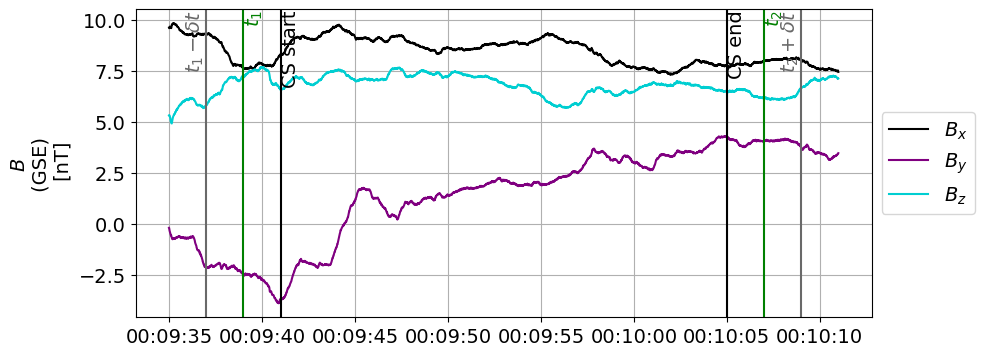

In [22]:
#%matplotlib widget


i = 0

time1 = pd.to_datetime(m1-dtb)-timedelta(seconds=2)
time2 = pd.to_datetime(m2+dtb)+timedelta(seconds=2)


st_idx_B2 = mag_arr.date.searchsorted(pd.to_datetime(time1))
end_idx_B2 = mag_arr.date.searchsorted(pd.to_datetime(time2))

st_idx_FPI2 = v_arr.date.searchsorted(pd.to_datetime(time1))
end_idx_FPI2 = v_arr.date.searchsorted(pd.to_datetime(time2))

#%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 14})

# ax_Vi = fig.add_subplot(111)
# labs = ax_Vi.get_xticklabels()

ax_B = fig.add_subplot(111)
ax_B.plot(mag_arr['date'][st_idx_B2:end_idx_B2],mag_arr['Bx'][st_idx_B2:end_idx_B2], color ='black',label='$B_x$')
ax_B.plot(mag_arr['date'][st_idx_B2:end_idx_B2],mag_arr['By'][st_idx_B2:end_idx_B2], color ='purple',label='$B_y$')
ax_B.plot(mag_arr['date'][st_idx_B2:end_idx_B2],mag_arr['Bz'][st_idx_B2:end_idx_B2], color ='darkturquoise',label='$B_z$')
ax_B.set_ylabel('$B$ \n (GSE) \n [nT]')
ax_B.grid('on')
#ax_B.tick_params( axis='x',labelbottom=False)
ax_B.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,0]), color = 'green')
ax_B.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,1]), color = 'green')
ax_B.axvline(x = pd.to_datetime(times_temp[0]), color = 'k', label = 'start')
ax_B.axvline(x = pd.to_datetime(times_temp[1]), color = 'k', label = 'end')
ax_B.axvline(x = pd.to_datetime(v1a), color = 'dimgray')
ax_B.axvline(x = pd.to_datetime(v2a), color = 'dimgray')
ax_B.text(pd.to_datetime(jet_candidate_timeranges[i,0]), 1, '$t_1$', color='green', ha='left', va='top', rotation=90,
                     transform=ax_B.get_xaxis_transform())
ax_B.text(pd.to_datetime(jet_candidate_timeranges[i,1]), 1, '$t_2$', color='green', ha='left', va='top', rotation=90,
                     transform=ax_B.get_xaxis_transform())
ax_B.text(pd.to_datetime(times_temp[0]), 1, 'CS start', color='k', ha='left', va='top', rotation=90,
                     transform=ax_B.get_xaxis_transform())    
ax_B.text(pd.to_datetime(times_temp[1]), 1, 'CS end', color='k', ha='left', va='top', rotation=90,
                     transform=ax_B.get_xaxis_transform())    

ax_B.text(pd.to_datetime(v1a), 1, '$t_1 - \delta t$', color='dimgray', ha='right', va='top', rotation=90,
                 transform=ax_B.get_xaxis_transform())
ax_B.text(pd.to_datetime(v2a), 1, '$t_2 + \delta t$', color='dimgray', ha='right', va='top', rotation=90,
                 transform=ax_B.get_xaxis_transform())



# ax_Vi.plot(v_arr['date'][st_idx_FPI2:end_idx_FPI2],v_arr['Vix'][st_idx_FPI2:end_idx_FPI2], color ='black',label='$V_{ix}$')
# ax_Vi.plot(v_arr['date'][st_idx_FPI2:end_idx_FPI2],v_arr['Viy'][st_idx_FPI2:end_idx_FPI2], color ='purple',label='$V_{iy}$')
# ax_Vi.plot(v_arr['date'][st_idx_FPI2:end_idx_FPI2],v_arr['Viz'][st_idx_FPI2:end_idx_FPI2], color ='darkturquoise',label='$V_{iz}$')
# ax_Vi.set_ylabel('$V_i$ \n (GSE) \n [km/s]')
# ax_Vi.grid('on')
# ax_Vi.legend(loc='upper right')
# #ax_Vi.tick_params( axis='x',labelbottom=False)
# ax_Vi.axvline(x = pd.to_datetime(v1a), color = 'dimgray')
# ax_Vi.axvline(x = pd.to_datetime(v2a), color = 'dimgray')
# ax_Vi.axvline(x = pd.to_datetime(times_temp[0]), color = 'k', label = 'start')
# ax_Vi.axvline(x = pd.to_datetime(times_temp[1]), color = 'k', label = 'end')
# ax_Vi.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,0]), color = 'green')
# ax_Vi.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,1]), color = 'green')



# Shrink current axis 
box = ax_B.get_position()
ax_B.set_position([box.x0, box.y0, box.width * 0.95, box.height])
# Put a legend to the right of the current axis
ax_B.legend(['$B_x$','$B_y$','$B_z$'],loc='center left', bbox_to_anchor=(1, 0.5))

# box = ax_Vi.get_position()
# ax_Vi.set_position([box.x0, box.y0, box.width * 0.95, box.height])
# # Put a legend to the right of the current axis
# ax_Vi.legend(['$V_x$','$V_y$','$V_z$'],loc='center left', bbox_to_anchor=(1, 0.5))




# plt.tight_layout()
# plt.subplots_adjust(hspace=0.0)